In [2]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "C:/Users/ICT01_20/Desktop/food-5"
categories  = os.listdir(caltech_dir)
nb_classes = len(categories )
image_w = 128
image_h = 128

X = []
y = []

In [2]:
import numpy as np
for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.JPG")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)

train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
xy = (X_train, X_test, X_val , y_train, y_test,y_val )
np.save("C:/Users/ICT01_20/Desktop/food-5-2", xy)

print("ok", len(y))

계란찜  파일 길이 :  784
계란찜  :  C:/Users/ICT01_20/Desktop/food-5/계란찜\Img_125_0000.jpg
계란찜  :  C:/Users/ICT01_20/Desktop/food-5/계란찜\Img_125_0871.jpg
고사리나물  파일 길이 :  896
고사리나물  :  C:/Users/ICT01_20/Desktop/food-5/고사리나물\Img_041_0000.JPG
고사리나물  :  C:/Users/ICT01_20/Desktop/food-5/고사리나물\Img_041_0782.jpg
삼계탕  파일 길이 :  864
삼계탕  :  C:/Users/ICT01_20/Desktop/food-5/삼계탕\Img_138_0000.jpg
삼계탕  :  C:/Users/ICT01_20/Desktop/food-5/삼계탕\Img_138_0785.jpg
오징어채볶음  파일 길이 :  704
오징어채볶음  :  C:/Users/ICT01_20/Desktop/food-5/오징어채볶음\Img_087_0003.jpg
오징어채볶음  :  C:/Users/ICT01_20/Desktop/food-5/오징어채볶음\Img_087_1070.jpg
콩자반  파일 길이 :  675
콩자반  :  C:/Users/ICT01_20/Desktop/food-5/콩자반\Img_025_0001.jpg
ok 3923


In [2]:
import os, glob, numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
#np_load_old = np.load
#np.load = lambda *a, **k : np_load_old(*a, allow_pickle=True, **k)
#np.load = np_load_old

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, X_val , y_train, y_test, y_val= np.load('C:/Users/ICT01_20/Desktop/food-5-2.npy',allow_pickle=True
)
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.


(2353, 128, 128, 3)
2353


In [3]:
#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_val = X_test.astype(float) / 255

In [4]:
######## ------------vgg net  사용 
from keras import models, layers
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()









_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__

In [6]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(5, activation='softmax'))
 

In [7]:
additional_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 58,767,173
Trainable params: 44,052,485
Non-trainable params: 14,714,688
_______________________________________________________

In [8]:
model_dir = './test'
model_path = model_dir + '/vgg16.model'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
additional_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [10]:
history =  additional_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), 
                    callbacks=[checkpoint,early_stopping])

Train on 2353 samples, validate on 785 samples
Epoch 1/20
2353/2353 [==============================] - 21s 9ms/step - loss: 0.3685 - acc: 0.8793 - val_loss: 0.4564 - val_acc: 0.8306

Epoch 00001: val_loss improved from inf to 0.45637, saving model to ./test/vgg16.model
Epoch 2/20
2353/2353 [==============================] - 21s 9ms/step - loss: 0.2224 - acc: 0.9303 - val_loss: 0.4258 - val_acc: 0.8369

Epoch 00002: val_loss improved from 0.45637 to 0.42582, saving model to ./test/vgg16.model
Epoch 3/20
2353/2353 [==============================] - 21s 9ms/step - loss: 0.1491 - acc: 0.9567 - val_loss: 0.3325 - val_acc: 0.8688

Epoch 00003: val_loss improved from 0.42582 to 0.33254, saving model to ./test/vgg16.model
Epoch 4/20
2353/2353 [==============================] - 21s 9ms/step - loss: 0.0959 - acc: 0.9741 - val_loss: 0.2445 - val_acc: 0.9083

Epoch 00004: val_loss improved from 0.33254 to 0.24454, saving model to ./test/vgg16.model
Epoch 5/20
2353/2353 [===========================

In [12]:
print("정확도 : %.4f" % (additional_model.evaluate(X_test, y_test)[1]))

785/785 [==============================] - 4s 5ms/step
정확도 : 0.9261


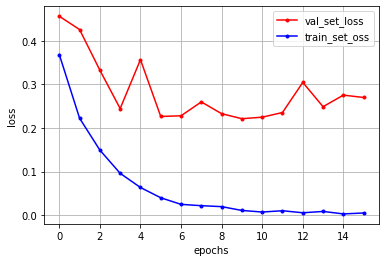

In [13]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [1]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "C:/Users/ICT01_20/Documents/study/test1"
categories  = os.listdir(caltech_dir)
nb_classes = len(categories )

image_w = 128
image_h = 128

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)
    
X = np.array(X)
model = load_model('./test/vgg16.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

for i in prediction:
    pre_ans = i.argmax()  
    print(i)
    print(pre_ans)
    pre_ans_str = categories[pre_ans]
    print(i,"해당 "+"이미지는 "+pre_ans_str+"로 추정됩니다.")
  

Using TensorFlow backend.













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




C:\Users\ICT01_20\Anaconda3\envs\a\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[1.000 0.000 0.000 0.000 0.000]
0
[1.000 0.000 0.000 0.000 0.000] 해당 이미지는 캡처.PNG로 추정됩니다.
[1.000 0.000 0.000 0.000 0.000]
0
[1.000 0.000 0.000 0.000 0.000] 해당 이미지는 캡처.PNG로 추정됩니다.
[0.000 1.000 0.000 0.000 0.000]
1
[0.000 1.000 0.000 0.000 0.000] 해당 이미지는 캡처1.PNG로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000]
2
[0.000 0.000 1.000 0.000 0.000] 해당 이미지는 캡처2.PNG로 추정됩니다.
[0.000 0.000 0.000 1.000 0.000]
3
[0.000 0.000 0.000 1.000 0.000] 해당 이미지는 캡처3.PNG로 추정됩니다.
[0.000 0.000 0.000 0.000 1.000]
4
[0.000 0.000 0.000 0.000 1.000] 해당 이미지는 캡처4.PNG로 추정됩니다.
